Train shape: (52099, 29)
Test shape: (11275, 28)
Class Balance (Winners):
Winner
0    0.897349
1    0.102651
Name: proportion, dtype: float64
Unique Races: 5337
Unique Horses: 9723
Avg runners per race: 9.761851227281245
✅ Exported market odds to data/market/betfair_sp.csv


✅ Exported leak-free market odds to data/market/betfair_sp_prerace.csv
Train missing:


,Missing Count,%
meanRunners,203,0.389643
MarketOdds_2ndPreviousRun,202,0.387723
Speed_2ndPreviousRun,202,0.387723
JockeyRating,143,0.274477
Speed_PreviousRun,92,0.176587
NMFPLTO,92,0.176587
MarketOdds_PreviousRun,92,0.176587
daysSinceLastRun,66,0.126682
TrainerRating,38,0.072938
DamsireRating,2,0.003839


Test missing:


,Missing Count,%
meanRunners,31,0.274945
Speed_2ndPreviousRun,30,0.266075
MarketOdds_2ndPreviousRun,30,0.266075
JockeyRating,22,0.195122
Speed_PreviousRun,16,0.141907
NMFPLTO,16,0.141907
MarketOdds_PreviousRun,16,0.141907
daysSinceLastRun,13,0.115299
TrainerRating,9,0.079823
SireRating,1,0.008869


Min runners: 2
Max runners: 31


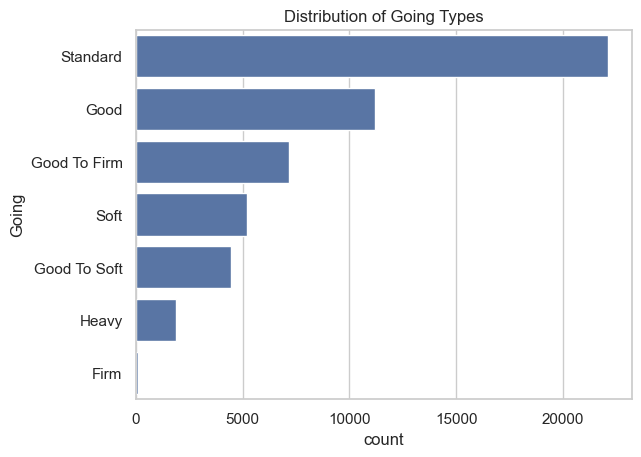

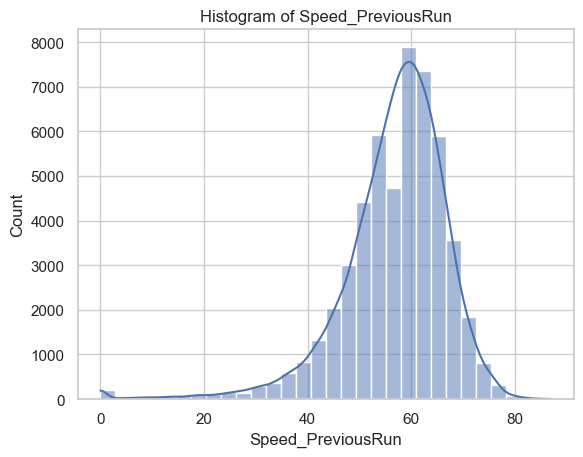

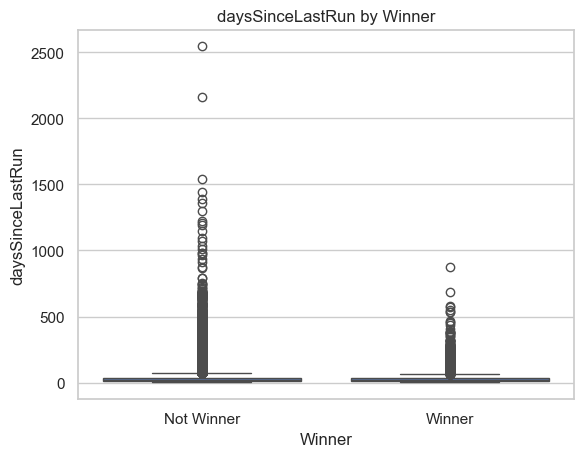

✅ Cleaned data saved to data/processed/


In [1]:
# %%
# 📟 Exploratory Data Analysis (Notebook 01)
# ------------------------------------------
# This notebook prepares training/testing data for modeling and extracts market odds for edge evaluation.

# %%
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

# ---- Paths --------------------------------------------------
BASE = Path.cwd().parent        # one level up from notebooks/
DATA_RAW = BASE / "data" / "raw"
DATA_PROCESSED = BASE / "data" / "processed"
DATA_MARKET = BASE / "data" / "market"

TRAIN_PATH = DATA_RAW / "train.csv"
TEST_PATH  = DATA_RAW / "test.csv"

# ---- Load Datasets ------------------------------------------
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# ---- Create Target Column -----------------------------------
train["Winner"] = (train["Position"] == 1).astype(int)

# ---- Basic Stats --------------------------------------------
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("Class Balance (Winners):")
print(train["Winner"].value_counts(normalize=True))

print("Unique Races:", train["Race_ID"].nunique())
print("Unique Horses:", train["Horse"].nunique())
print("Avg runners per race:", train.groupby("Race_ID").size().mean())

# ---- Extract Market Odds for Edge Calculation ---------------
market_cols = ["Race_ID", "Horse", "betfairSP"]
train_market = train[market_cols].copy()
test_market = test[market_cols].copy()

# Rename for clarity
train_market.rename(columns={"betfairSP": "Market_Odds"}, inplace=True)
test_market.rename(columns={"betfairSP": "Market_Odds"}, inplace=True)

# Add Market_Prob (implied probability)
train_market["Market_Prob"] = 1 / train_market["Market_Odds"]
test_market["Market_Prob"] = 1 / test_market["Market_Odds"]

# ✅ Export market data for use in backtesting only (NOT for training)
DATA_MARKET.mkdir(parents=True, exist_ok=True)
market_combined = pd.concat([train_market, test_market])
market_combined.to_csv(DATA_MARKET / "betfair_sp.csv", index=False)
print("✅ Exported market odds to data/market/betfair_sp.csv")

# === Create PRERACE-ONLY market file for model feature merges ===
leak_cols = ["betfairSP", "Position", "timeSecs", "pdsBeaten", "NMFP"]
market_prerace = market_combined.drop(columns=[col for col in leak_cols if col in market_combined.columns], errors="ignore")
market_prerace.to_csv(DATA_MARKET / "betfair_sp_prerace.csv", index=False)
print("✅ Exported leak-free market odds to data/market/betfair_sp_prerace.csv")

# 🚫 DO NOT MERGE MARKET ODDS INTO TRAINING DATA TO AVOID LEAKAGE

# ---- Leakage Columns (Remove from model input) --------------
LEAK_COLS = ["Position", "betfairSP", "timeSecs", "pdsBeaten", "NMFP"]
train_leaky = train.copy()
train = train.drop(columns=LEAK_COLS)
test = test.drop(columns=[col for col in LEAK_COLS if col in test.columns])

# ---- Missing Data Handling ----------------------------------
def missing_report(df):
    miss = df.isnull().sum()
    miss = miss[miss > 0]
    return pd.DataFrame({"Missing Count": miss, "%": miss / len(df) * 100}).sort_values(by="%", ascending=False)

print("Train missing:")
display(missing_report(train))
print("Test missing:")
display(missing_report(test))

# Impute numerics
num_cols = train.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    if train[col].isnull().any():
        train[col] = train.groupby(["Course", "Going"])[col].transform(lambda x: x.fillna(x.median()))
        test[col] = test.groupby(["Course", "Going"])[col].transform(lambda x: x.fillna(x.median()))

# Fill categoricals
cat_cols = train.select_dtypes(include=["object"]).columns
for col in cat_cols:
    train[col] = train[col].fillna("Unknown")
    test[col] = test[col].fillna("Unknown")

# ---- EDA Visuals --------------------------------------------
race_sizes = train_leaky.groupby("Race_ID").size()
print("Min runners:", race_sizes.min())
print("Max runners:", race_sizes.max())

sns.countplot(y=train["Going"], order=train["Going"].value_counts().index)
plt.title("Distribution of Going Types")
plt.show()

sns.histplot(train["Speed_PreviousRun"], bins=30, kde=True)
plt.title("Histogram of Speed_PreviousRun")
plt.show()

sns.boxplot(x="Winner", y="daysSinceLastRun", data=train_leaky)
plt.title("daysSinceLastRun by Winner")
plt.xticks([0, 1], ["Not Winner", "Winner"])
plt.show()

# ---- Export Cleaned Model Inputs ----------------------------
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
train.to_csv(DATA_PROCESSED / "train_cleaned.csv", index=False)
test.to_csv(DATA_PROCESSED / "test_cleaned.csv", index=False)
print("✅ Cleaned data saved to data/processed/")


